# Federated Learning

In [1]:
%load_ext autoreload
%autoreload 2

In [29]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import sys
sys.path.insert(0, '..')

In [4]:
from data.frecency import sample, frecency_points
from data.frecency import sample_suggestions_normal as sample_suggestions

## Linear Regression

This section is mostly to check that's it possible to fit a linear model perfectly to the data.

In [5]:
from sklearn.linear_model import LinearRegression

To fit a model, we sample a lot of these scores and also add noise on top to make the problem more similar to the real application.

In [6]:
n = int(1e6)
noise = np.random.normal(0, 2, size=(n))
X, y = sample(n)
y += noise

In [7]:
model = LinearRegression(fit_intercept=False)
model.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=False)

The resulting coefficients are extremely close to the actual frecency weights. How close they are depends on how much noise we add to the data matrix.

In [8]:
zip(model.coef_, frecency_points)

[(120.00333500654246, 120.0),
 (35.995557550483873, 36.0),
 (97.994996557300183, 98.0),
 (13.992650899036075, 14.0),
 (19.993039069792342, 20.0),
 (99.97600899995517, 100.0),
 (140.00937856149761, 140.0),
 (69.999480626657714, 70.0),
 (199.99165543624855, 200.0),
 (42.001243539264372, 42.0),
 (60.007903363545338, 60.0),
 (140.01511441895124, 140.0),
 (11.991131134526411, 12.0),
 (60.002935871815112, 60.0),
 (84.003882561214098, 84.0)]

In [9]:
model.coef_ - frecency_points

array([ 0.00333501, -0.00444245, -0.00500344, -0.0073491 , -0.00696093,
       -0.023991  ,  0.00937856, -0.00051937, -0.00834456,  0.00124354,
        0.00790336,  0.01511442, -0.00886887,  0.00293587,  0.00388256])

## Ranking and SVM loss

Now, we make the problem slightly more difficult: Instead of just learning the frecency function from data, we try to learn it from user interactions. The training data now consists of a variable number of history suggestions and their respective features. The label corresponds to the suggestion that the user clicked on. We still assume that the user clicks on the item with the highest frecency score.

### Preprocessing

Gradient descent generally works better when the data is centered around the origin:

In [10]:
from utils import normalize

In [11]:
X = normalize(X)

### Optimizers

In [12]:
from optimizers import GradientDescent, AdaptiveGradientDescent, DecayedGradientDescent, RProp, Adam

### Hinge Loss (SVM loss)

To supervise training, we keep logging the loss:

In [13]:
def svm_loss(preds, ys, delta=0):
    correct = ys.argmax()
    score_correct = preds[correct]
    
    loss = 0
    
    for i, pred in enumerate(preds):
        loss += max(0, pred + delta - score_correct)            
            
    return loss

### Helpers

During training, we want to supervise the learning process and save the best models.

In [14]:
from utils import ModelCheckpoint

accuracy needs to be measured carefully here: In our simulation, we assume that the current frecency is the perfect ranking function. But because items sometimes get the same frecency scores, there can be more than one correct answer:

In [15]:
def rank_accuracy(y, preds):
    correct = 0.
    
    for yi, pi in zip(y, preds):
        if yi[pi.argmax()] == yi.max():
            correct += 1
            
    return correct / len(y)

The `SVMRanking` class is the main mechanism for fitting models.

In [16]:
class SVMRanking:
    def __init__(self, delta):
        self.delta = delta
        
    def fit(self, data_generator, optimizer, num_iterations=10, callbacks=[]):
        X, y = data_generator(1)
        num_features = X[0].shape[1]
        self.W = frecency_points + (np.random.random(size=(num_features)) - 0.5) * 100
        
        for j in range(num_iterations):
            X, y = data_generator(4000)
            
            preds = self.predict(X)
            gradient = np.zeros(num_features)

            for xi, pi, yi in zip(X, preds, y):
                correct = yi.argmax()
                score_correct = pi[correct]

                for i, predicted_score in enumerate(pi):
                    gradient -= xi[i] * max(0, predicted_score + self.delta - score_correct)
            
            gradient /= len(X)
            
            loss = np.mean([svm_loss(pi, yi) for pi, yi in zip(self.predict(X), y)])
            accuracy = rank_accuracy(y, model.predict(X))
            
            print("[%d/%d] training: %.5f loss, %.3f accuracy" % (j + 1, num_iterations, loss, accuracy))
            
            for callback in callbacks:
                callback(self)
            
            self.W += optimizer(gradient)
            
    def predict(self, X):
        preds = []
        
        for x in X:
            scores = x.dot(self.W)
            preds.append(scores)
        
        return preds

In [23]:
np.random.seed(0)
model = SVMRanking(delta=0.)
model.fit(data_generator=sample_suggestions,
          optimizer=GradientDescent(30.),
          num_iterations=48,
          callbacks=[ModelCheckpoint(rank_accuracy, sample_suggestions)])

[1/48] training: 11.71683 loss, 0.738 accuracy
[ModelCheckpoint] New best model with 0.73150 validation accuracy
[2/48] training: 122.41008 loss, 0.731 accuracy
validation: 0.721 accuracy
[3/48] training: 55.80964 loss, 0.906 accuracy
[ModelCheckpoint] New best model with 0.91160 validation accuracy
[4/48] training: 6.76885 loss, 0.954 accuracy
[ModelCheckpoint] New best model with 0.95830 validation accuracy
[5/48] training: 2.21581 loss, 0.958 accuracy
[ModelCheckpoint] New best model with 0.96020 validation accuracy
[6/48] training: 1.10265 loss, 0.965 accuracy
[ModelCheckpoint] New best model with 0.96490 validation accuracy
[7/48] training: 0.85294 loss, 0.981 accuracy
[ModelCheckpoint] New best model with 0.98130 validation accuracy
[8/48] training: 0.57912 loss, 0.980 accuracy
validation: 0.980 accuracy
[9/48] training: 0.32446 loss, 0.982 accuracy
validation: 0.981 accuracy
[10/48] training: 0.32911 loss, 0.980 accuracy
[ModelCheckpoint] New best model with 0.98140 validation a

In [25]:
np.random.seed(0)
opt = AdaptiveGradientDescent(0.1, len(frecency_points))
model = SVMRanking(delta=0.)
model.fit(data_generator=sample_suggestions,
          optimizer=opt,
          num_iterations=48,
          callbacks=[ModelCheckpoint(rank_accuracy,  sample_suggestions)])

[1/48] training: 11.71683 loss, 0.738 accuracy
[ModelCheckpoint] New best model with 0.73150 validation accuracy
[2/48] training: 13.43970 loss, 0.728 accuracy
validation: 0.721 accuracy
[3/48] training: 11.48569 loss, 0.748 accuracy
[ModelCheckpoint] New best model with 0.73510 validation accuracy
[4/48] training: 11.15089 loss, 0.749 accuracy
validation: 0.734 accuracy
[5/48] training: 11.64325 loss, 0.739 accuracy
[ModelCheckpoint] New best model with 0.74280 validation accuracy
[6/48] training: 10.64545 loss, 0.849 accuracy
[ModelCheckpoint] New best model with 0.84070 validation accuracy
[7/48] training: 10.95008 loss, 0.839 accuracy
validation: 0.837 accuracy
[8/48] training: 11.11485 loss, 0.834 accuracy
validation: 0.838 accuracy
[9/48] training: 9.85802 loss, 0.845 accuracy
validation: 0.829 accuracy
[10/48] training: 10.26959 loss, 0.839 accuracy
validation: 0.839 accuracy
[11/48] training: 10.19416 loss, 0.834 accuracy
validation: 0.840 accuracy
[12/48] training: 8.56436 los

After fitting, we can compare the learned weights with the true frecency scores. Note that the values themselves are very different now but that the ordering is nearly the same as in the real algorithm. This shows that we are ranking very similarly to the real algorithm but that the optimization process did not fully reach the global optimum.

In [26]:
ais = np.argsort(frecency_points)
zip(frecency_points[ais], model.W[ais])

[(12.0, 14.328107294741949),
 (14.0, 10.147936225293185),
 (20.0, 34.335460264505343),
 (36.0, 34.335334892244539),
 (42.0, 34.338056202528762),
 (60.0, 34.335892421808076),
 (60.0, 34.350521497586705),
 (70.0, 34.335328740904643),
 (84.0, 61.827233423435842),
 (98.0, 61.827444877537495),
 (100.0, 61.827442586893319),
 (120.0, 116.45108591309054),
 (140.0, 116.45141094451398),
 (140.0, 116.45498071467374),
 (200.0, 244.46689170495839)]

Still, the model is correct most of the time:

In [27]:
X, y = sample_suggestions(10000)
rank_accuracy(y, model.predict(X))

0.97

### Side note: Evaluation during training in production

If we only use 400 data points for validating the current model, then this is not enough to properly assess the model quality.
The accuracies jump too much.
However, this evaluation could still be used to test that the model is not completely off.

(array([   3.,   10.,   30.,  114.,  189.,  234.,  308.,   81.,   26.,    4.]),
 array([ 0.94   ,  0.94575,  0.9515 ,  0.95725,  0.963  ,  0.96875,
         0.9745 ,  0.98025,  0.986  ,  0.99175,  0.9975 ]),
 <a list of 10 Patch objects>)

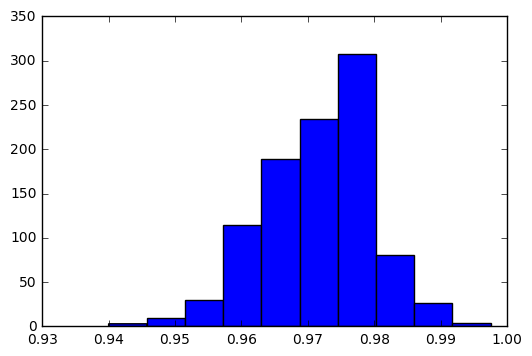

In [30]:
X, y = sample_suggestions(1000 * 400)
accuracies = []

for i in range(0, len(X) - 400, 400):
    Xi, yi = X[i:i+400], y[i:i+400]
    acc = rank_accuracy(yi, model.predict(Xi))
    accuracies.append(acc)
    
plt.hist(sorted(accuracies))

## Frequency

We still need to take into account that users visit links more than once.
How often a user visits a link is sampled from an exponential distribution in this simulation:

(array([ 496.,  259.,  118.,   61.,   31.,   15.,    9.,    5.,    2.,    4.]),
 array([  0. ,   4.9,   9.8,  14.7,  19.6,  24.5,  29.4,  34.3,  39.2,
         44.1,  49. ]),
 <a list of 10 Patch objects>)

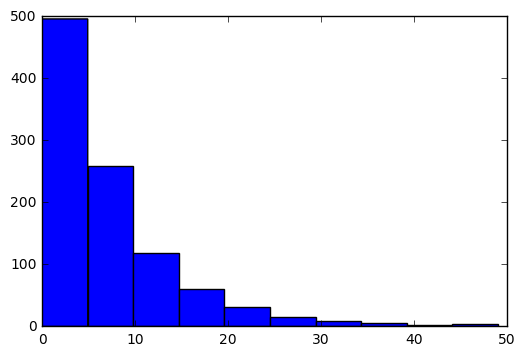

In [31]:
frequencies = np.int32(np.random.exponential(7, size=(1000)))
plt.hist(frequencies)

In [32]:
def sample_url_features(num_samples):
    frequencies = np.int32(np.random.exponential(7, size=num_samples)) + 1
    frequencies = np.int32(np.ones(num_samples))
    X = []
    
    for frequency in frequencies:
        num_sampled = min(10, frequency)
        features = sample_weighted(num_sampled, weights).sum(axis=0)
        X.append(frequency / num_sampled * features)
        
    return np.array(X)

In [34]:
model = SVMRanking(delta=0.)
model.fit(data_generator=sample_suggestions,
          optimizer=GradientDescent(30.),
          num_iterations=48,
          callbacks=[ModelCheckpoint(rank_accuracy, sample_suggestions, 10000)])

[1/48] training: 10.96645 loss, 0.742 accuracy
[ModelCheckpoint] New best model with 0.73000 validation accuracy
[2/48] training: 2.53767 loss, 0.917 accuracy
[ModelCheckpoint] New best model with 0.92450 validation accuracy
[3/48] training: 0.92663 loss, 0.934 accuracy
[ModelCheckpoint] New best model with 0.93510 validation accuracy
[4/48] training: 0.31598 loss, 0.948 accuracy
[ModelCheckpoint] New best model with 0.94480 validation accuracy
[5/48] training: 0.25366 loss, 0.950 accuracy
[ModelCheckpoint] New best model with 0.94820 validation accuracy
[6/48] training: 0.13407 loss, 0.959 accuracy
[ModelCheckpoint] New best model with 0.95080 validation accuracy
[7/48] training: 0.13610 loss, 0.954 accuracy
[ModelCheckpoint] New best model with 0.95680 validation accuracy
[8/48] training: 0.11580 loss, 0.952 accuracy
validation: 0.952 accuracy
[9/48] training: 0.07629 loss, 0.954 accuracy
validation: 0.956 accuracy
[10/48] training: 0.08351 loss, 0.956 accuracy
validation: 0.953 accu

## Federated Learning

To implement a federated version of the model above, we have to create a `Client` class that completely encapsulates training data. Only the `Client` can compute gradients based on its own data. While the `Server` is the main class for controlling the training process, it can only request gradients from clients.

In [35]:
import random

In [36]:
class Server:
    def __init__(self, clients):
        self.clients = clients
        
        num_features = len(frecency_points)
        self.W = frecency_points + (np.random.random(size=(num_features)) - 0.5) * 100
    
    def fit(self, optimizer, num_iterations, num_clients_per_iteration, callbacks=[]):
        for j in range(num_iterations):
            clients = random.sample(self.clients, num_clients_per_iteration)
            updates, losses = zip(*[client.request_update(self) for client in clients])
            
            gradient = np.mean(updates, axis=0)
            loss = np.mean(losses, axis=0)
            
            print("[%d/%d] training loss across clients %.5f" % (j + 1, num_iterations, loss))
            
            for callback in callbacks:
                callback(self)
            
            self.W += optimizer(gradient)
            
    def predict(self, X):
        preds = []
        
        for x in X:
            scores = x.dot(self.W)
            preds.append(scores)
        
        return preds

In [37]:
class Client:
    def __init__(self, data_generator, delta=0):
        self.data_generator = data_generator
        self.delta = 0
    
    def request_update(self, model):
        X, y = self.data_generator()
        preds = model.predict(X)
        
        num_features = X[0].shape[1]
        gradient = np.zeros(num_features)
        loss = 0

        for xi, pi, yi in zip(X, preds, y):
            correct = yi.argmax()
            score_correct = pi[correct]

            for i, predicted_score in enumerate(pi):
                gradient -= xi[i] * max(0, predicted_score + self.delta - score_correct)
            
            loss += svm_loss(pi, yi)
                
        gradient /= len(X)
        loss /= len(X)
        
        return gradient, loss

How many data points a user has in each round is sampled from the following exponential distribution:

(array([ 718.,  198.,   64.,    0.,   11.,    7.,    0.,    1.,    0.,    1.]),
 array([ 1. ,  1.7,  2.4,  3.1,  3.8,  4.5,  5.2,  5.9,  6.6,  7.3,  8. ]),
 <a list of 10 Patch objects>)

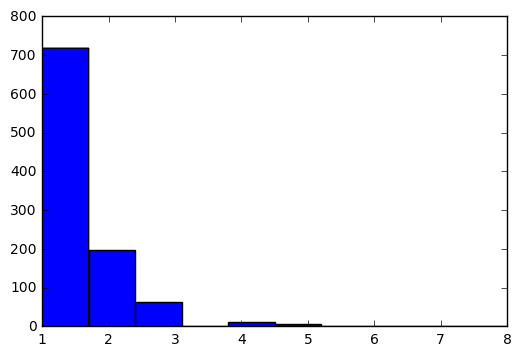

In [38]:
num_datapoints = np.int32(np.random.exponential(.8, size=(1000))) + 1
plt.hist(num_datapoints)

We have 5000 clients:

In [40]:
clients = [Client(lambda: sample_suggestions(np.int32(np.random.exponential(.8)) + 1)) for _ in range(5000)]

In [42]:
server = Server(clients)
server.fit(optimizer=GradientDescent(30.),
          num_iterations=48,
           num_clients_per_iteration=400,
          callbacks=[ModelCheckpoint(rank_accuracy, sample_suggestions, 10000)])

[1/48] training loss across clients 6.35107
[ModelCheckpoint] New best model with 0.77460 validation accuracy
[2/48] training loss across clients 8.79592
[ModelCheckpoint] New best model with 0.92450 validation accuracy
[3/48] training loss across clients 3.18923
validation: 0.924 accuracy
[4/48] training loss across clients 1.12846
[ModelCheckpoint] New best model with 0.95640 validation accuracy
[5/48] training loss across clients 0.71365
validation: 0.956 accuracy
[6/48] training loss across clients 0.36722
validation: 0.955 accuracy
[7/48] training loss across clients 0.43015
validation: 0.955 accuracy
[8/48] training loss across clients 0.09179
[ModelCheckpoint] New best model with 0.95710 validation accuracy
[9/48] training loss across clients 0.10533
[ModelCheckpoint] New best model with 0.95750 validation accuracy
[10/48] training loss across clients 0.07912
[ModelCheckpoint] New best model with 0.96080 validation accuracy
[11/48] training loss across clients 0.05718
validation

=> The model quality improved from 70% to >97% validation accuracy.

# Notes 

Simplifications made:

- All users sample from the same distribution
- `ModelCheckpoint` cannot be based on validation data in the actual implementation
- Users should run more than one SGD iteration locally

## To make fitting easier

- Fair initialization
- Normalize data (0-center)
- Remove features with a value of 0

## Still missing

- Implement frequency part (switch from one-hot encoding to up to sum of 10 and add multiplicative factor)